# Пример простого импорта и запуска расчета c python API

Хабибуллин Ринат

версия 0.2 от 20.02.2023

***
Пример показывает как можно подключиться к `python API` для `Unifloc VBA` и сделать простой расчет.


Работать будет только под windows так как расчеты проводит в итоге Excel


In [1]:
"""
Импорт унифлока зависит от корректных путей к надстройке
Путь задается вручную в явном виде (так проще всего)
"""

unifloc_path = r'C:\unifloc\unifloc_vba'
unifloc_xlam = unifloc_path +r'\UniflocVBA_7.xlam'
print('Путь к надстройке Unifloc VBA -- '+ unifloc_xlam)

import sys
sys.path.insert(0, unifloc_path) # добавим в путь поиска пакетов python папку где находится репозиторий Unifloc VBA
import unifloc_vba_python_api.python_api as unifloc # импортируем python_api для Unifloc VBA

# создаем объект имеющий доступ к расчетам Unifloc VBA
unf = unifloc.API(unifloc_xlam)

print('объект unf обеспечивает доступ к API Unifloc VBA')

Путь к надстройке Unifloc VBA -- C:\unifloc\unifloc_vba\UniflocVBA_7.xlam
объект unf обеспечивает доступ к API Unifloc VBA


In [2]:
# импортируем дополнительные библиотеки 
import matplotlib.pyplot as plt
import numpy as np

## Задаем параметры флюида и формируем json строку кодирующую параметры флюида

Подсказку по аргументам функций unifloc VBA можно получить используя функцию `help`или можно посмотреть непосредственно в коде. Ниже приведен пример. Обратите внимание, python чувствителен к регистру, поэтому надо в описании смотреть на строку задания функции где перечислены все аргументы с заданными значениями по умолчанию. В развернутом описании аргументов регистр может отличаться.

In [3]:
help(unf.encode_PVT)

Help on method encode_PVT in module unifloc_vba_python_api.python_api:

encode_PVT(gamma_gas=0.6, gamma_oil=0.86, gamma_wat=1, rsb_m3m3=100, pb_atma=0, t_res_C=80, bob_m3m3=0, muob_cP=0, PVT_corr_set=0) method of unifloc_vba_python_api.python_api.API instance
    ========== description ============== 
    Функция кодирования параметров PVT в строку,  для передачи PVT свойств в прикладные функции Унифлок. 
           
    ==========  arguments  ============== 
    
        gamma_gas - удельная плотность газа, по воздуху.  по умолчанию const_gg_ = 0.6    
    
        gamma_oil - удельная плотность нефти, по воде.  по умолчанию const_go_ = 0.86    
    
        gamma_wat - удельная плотность воды, по воде.  по умолчанию const_gw_ = 1    
    
        rsb_m3m3 - газосодержание при давлении насыщения, м3/м3.  по умолчанию const_rsb_default = 100    
    
        pb_atma - давление насыщения при заданной температуре, атма.  опциональный калибровочный параметр,  если не задан или = 0, то рас

In [4]:
# задаем флюид задавая все параметры.
# для наглядности используем имена аргументов для задания значений
fluid = unf.encode_PVT(gamma_gas=0.8, 
                       gamma_oil=0.82, 
                       gamma_wat=1.1, 
                       rsb_m3m3=120, 
                       pb_atma=150, 
                       t_res_C=80, 
                       bob_m3m3=1.2, 
                       muob_cP=0.5, 
                       PVT_corr_set=0)
# выведем итоговую json строку
print(fluid)

{"gamma_gas":0.8,"gamma_oil":0.82,"gamma_wat":1.1,"rsb_m3m3":120,"pb_atma":150,"t_res_C":80,"bob_m3m3":1.2,"muob_cP":0.5,"PVT_corr_set":0}


## Расчет газосодержания в нефти

Для примера рассчитаем значение газосодержания $r_s$ в заданной нефти и построим график зависимости газосодержания от давления

In [5]:
help(unf.PVT_rs_m3m3)

Help on method PVT_rs_m3m3 in module unifloc_vba_python_api.python_api:

PVT_rs_m3m3(p_atma, t_C, PVT_prop='') method of unifloc_vba_python_api.python_api.API instance
    ========== description ============== 
    расчет газосодержания при заданных p,t 
           
    ==========  arguments  ============== 
    
        p_atma - давление, атм    
    
        t_c - температура, с.    
    
        pvt_prop - строка с параметрами флюида,  используйте encode_pvt для ее генерации,  если задана перекрывает остальные параметры



In [6]:
# пример расчета газосодерждания при давлении 1 атм, и температуре 80 C
rs = unf.PVT_rs_m3m3(1, 80, fluid)
print(rs)

0.28612023857689795


In [7]:
# удобнее для чтения кода при вызове функций указывать названия аргументов
rs = unf.PVT_rs_m3m3(p_atma=1, t_C=80, PVT_prop=fluid)
print(rs)

0.28612023857689795


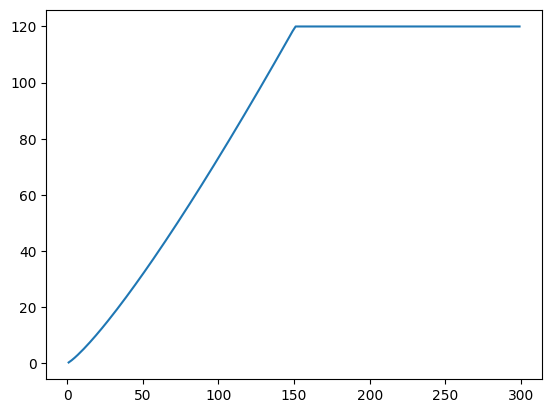

In [8]:
# для отрисовки графика сформируем массив давлений и рассчитаем для него значения газосодержания
plist = np.arange(1,300,2)
rslist = np.array([unf.PVT_rs_m3m3(p_atma=pi, t_C=80, PVT_prop=fluid) for pi in plist])

plt.plot(plist, rslist)
plt.show()

В Unifloc VAB python API генерируются функции не поддерживающие векторные расчеты numpy. В некоторых случаях для повышения наглядности расчетного кода необходимые функции можно векторизовать самостоятельно. Пример приведен ниже

In [9]:
# векторизуем функцию расчета газосодержания
rs_m3m3 = np.vectorize(unf.PVT_rs_m3m3)

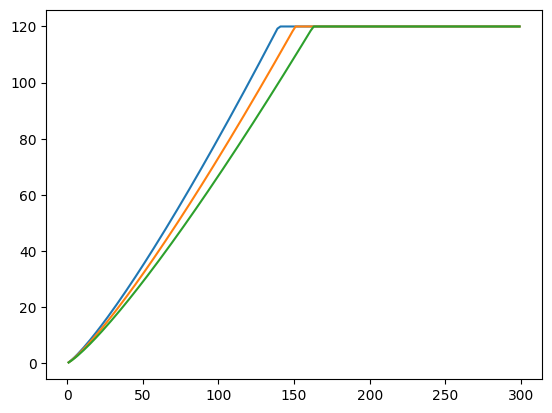

In [10]:
# для отрисовки графика сформируем массив давлений и рассчитаем для него значения газосодержания
plist = np.arange(1,300,2)

rslist = rs_m3m3(p_atma=plist, t_C=60, PVT_prop=fluid) 
plt.plot(plist, rslist)

rslist = rs_m3m3(p_atma=plist, t_C=80, PVT_prop=fluid) 
plt.plot(plist, rslist)

rslist = rs_m3m3(p_atma=plist, t_C=100, PVT_prop=fluid) 
plt.plot(plist, rslist)

plt.show()

Графики можно укасить, добавить подписи и легенду. Оставим это читателю в качестве упражнения

# работа с результатами в виде json строк

Многие функции Unifloc VBA могут выдавать результаты в виде json строк. Это может оказаться удобным для работы в python. Ниже базовый пример получения и расшифровки подобных результатов

In [12]:
unf.PVT_calc(10,20, fluid)

'{"rs_m3m3":6.02,"pb_atma":119.457,"bo_m3m3":1.006,"bg_m3m3":0.097,"bw_m3m3":1.001,"mu_oil_cP":11.922,"mu_gas_cP":0.01,"mu_wat_cP":1.261,"rho_oil_rc_kgm3":821.008,"rho_gas_rc_kgm3":10.099,"rho_wat_rc_kgm3":1098.447,"compressibility_oil_1atm":0.070615,"compressibility_gas_1atm":0.103882,"compressibility_wat_1atm":0.000033,"sigma_liq_Nm":0.028,"sigma_oil_gas_Nm":0.028,"sigma_wat_gas_Nm":0.064,"cp_oil_JkgC":2404.42,"cp_gas_JkgC":1779.876,"cv_gas_JkgC":1434.634,"cp_wat_JkgC":4176,"z":0.964,"sal_ppm":136861.032}'

Для работы с json можно импортировать соответствующий модуль. Документацию к нему легко найти в интернете.

In [13]:
import json

In [15]:
# получаем результат расчета в виде json строки
r = unf.PVT_calc(10,20, fluid)

# преобразуем результат в словарь
rd = json.loads(r)

# если словарь напечатать, то получим json подобную строку
print(rd)

{'rs_m3m3': 6.02, 'pb_atma': 119.457, 'bo_m3m3': 1.006, 'bg_m3m3': 0.097, 'bw_m3m3': 1.001, 'mu_oil_cP': 11.922, 'mu_gas_cP': 0.01, 'mu_wat_cP': 1.261, 'rho_oil_rc_kgm3': 821.008, 'rho_gas_rc_kgm3': 10.099, 'rho_wat_rc_kgm3': 1098.447, 'compressibility_oil_1atm': 0.070615, 'compressibility_gas_1atm': 0.103882, 'compressibility_wat_1atm': 3.3e-05, 'sigma_liq_Nm': 0.028, 'sigma_oil_gas_Nm': 0.028, 'sigma_wat_gas_Nm': 0.064, 'cp_oil_JkgC': 2404.42, 'cp_gas_JkgC': 1779.876, 'cv_gas_JkgC': 1434.634, 'cp_wat_JkgC': 4176, 'z': 0.964, 'sal_ppm': 136861.032}


In [16]:
# но со словарем можно работать достаточно гибко
print(rd.keys())

dict_keys(['rs_m3m3', 'pb_atma', 'bo_m3m3', 'bg_m3m3', 'bw_m3m3', 'mu_oil_cP', 'mu_gas_cP', 'mu_wat_cP', 'rho_oil_rc_kgm3', 'rho_gas_rc_kgm3', 'rho_wat_rc_kgm3', 'compressibility_oil_1atm', 'compressibility_gas_1atm', 'compressibility_wat_1atm', 'sigma_liq_Nm', 'sigma_oil_gas_Nm', 'sigma_wat_gas_Nm', 'cp_oil_JkgC', 'cp_gas_JkgC', 'cv_gas_JkgC', 'cp_wat_JkgC', 'z', 'sal_ppm'])


In [17]:
print(rd['rs_m3m3'])

6.02
